In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import reshape_as_image
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
# Define paths
# image_path = '/data/cse620b/ch12-data/C-megacities/Image__8bit_NirRGB/GF1_PMS2_E113.7_N30.2_20160614_L1A0001642547-MSS2.tif'
# label_path = '/data/cse620b/ch12-data/C-megacities/label_dense__color/GF1_PMS2_E113.7_N30.2_20160614_L1A0001642547-MSS2_dense.tif'
image_path =  'GF1_PMS2_E113.7_N30.2_20160614_L1A0001642547-MSS2.tif'
label_path = 'GF1_PMS2_E113.7_N30.2_20160614_L1A0001642547-MSS2_dense.tif'

# Define bounding box (row_start, row_stop), (col_start, col_stop)
row_start, row_stop = 1500, 2500
col_start, col_stop = 3500, 4500

window = ((col_start, col_stop ), (row_start, row_stop))

# Load image with bounding box
import warnings; warnings.filterwarnings('ignore', 'Dataset has no geotransform')
with rasterio.open(image_path) as src:
    image = src.read((1,2,3), window=window)
    image = reshape_as_image(image)
    print(f'Image shape: {image.shape}')  # (height, width, bands)

# Load labels with bounding box
with rasterio.open(label_path) as src:
    labels_rgb = src.read(window=window)
    labels_rgb = reshape_as_image(labels_rgb)
    print(f'Labels shape: {labels_rgb.shape}')  # (height, width, channels)

Image shape: (1000, 1000, 3)
Labels shape: (1000, 1000, 3)


(np.float64(-0.5), np.float64(999.5), np.float64(999.5), np.float64(-0.5))

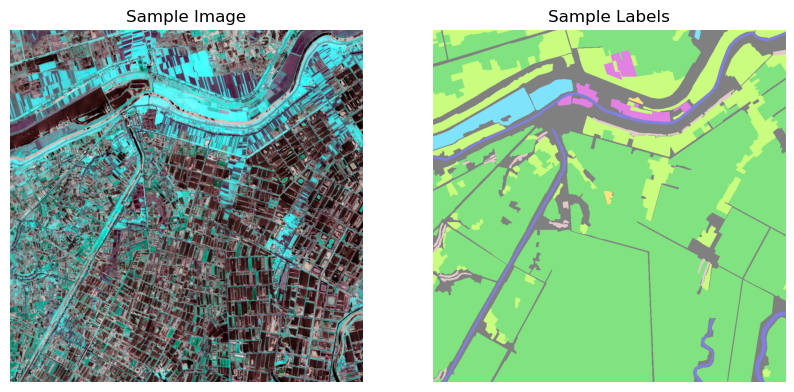

In [3]:
# Display the image
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(image)
plt.title('Sample Image')
plt.axis('off')
plt.subplot(122)
plt.imshow(labels_rgb, alpha=0.5)
plt.title('Sample Labels')
plt.axis('off')

In [23]:
# Define color to class mapping based on the dataset
color_to_name = {
    (0, 0, 0): 'unlabeled',
    (200, 0, 0): 'industrial_area',
    (0, 200, 0): 'paddy_field',
    (150, 250, 0): 'irrigated_field',
    (150, 200, 150): 'dry_cropland',
    (200, 0, 200): 'garden_land',
    (150, 0, 250): 'arbor_forest',
    (150, 150, 250): 'shrub_forest',
    (200, 150, 200): 'park',
    (250, 200, 0): 'natural_meadow',
    (200, 200, 0): 'artificial_meadow',
    (0, 0, 200): 'river',
    (250, 0, 150): 'urban_residential',
    (0, 150, 200): 'lake',
    (0, 200, 250): 'pond',
    (150, 200, 250): 'fish_pond',
    (250, 250, 250): 'snow',
    (200, 200, 200): 'bareland',
    (200, 150, 150): 'rural_residential',
    (250, 200, 150): 'stadium',
    (150, 150, 0): 'square',
    (250, 150, 150): 'road',
    (250, 150, 0): 'overpass',
    (250, 200, 250): 'railway_station',
    (200, 150, 0): 'airport',
}

label_colors = np.array(list(color_to_name.keys()))
label_names = np.array(list(color_to_name.values()))
color_to_label = {tuple(color): idx for idx, color in enumerate(label_colors)}

labels =  np.apply_along_axis(lambda x: color_to_label.get((x[0], x[1], x[2]), 0), axis=2, arr=labels_rgb)

UNLABELED = np.where(label_names == 'unlabeled')[0].item()

X shape: (847037, 3)
Y shape: (847037,)


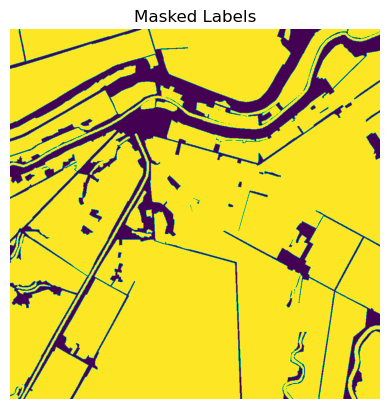

In [27]:
mask = labels != UNLABELED

X = image[mask, :]
Y = labels[mask]

print(f'X shape: {X.shape}')
print("Y shape:", Y.shape)

plt.imshow(mask)
plt.title('Masked Labels')
plt.axis('off')
plt.show()


In [28]:
# Create used_labels (the color codes) and used_names (the class names)
used_labels = np.unique(Y)
used_names = label_names[used_labels]

print(f'Used Labels (colors): {used_labels}')
print(f'Used Names (class names): {used_names}')

Used Labels (colors): [ 2  3  5  9 11 14 18]
Used Names (class names): ['paddy_field' 'irrigated_field' 'garden_land' 'natural_meadow' 'river'
 'pond' 'rural_residential']


In [33]:
# Split into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)
print(f'Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}')

Training samples: 677629, Testing samples: 169408


## Exploratory Data Analysis

It is important to look at the distribution of the data to understand its characteristics and identify any patterns or anomalies.

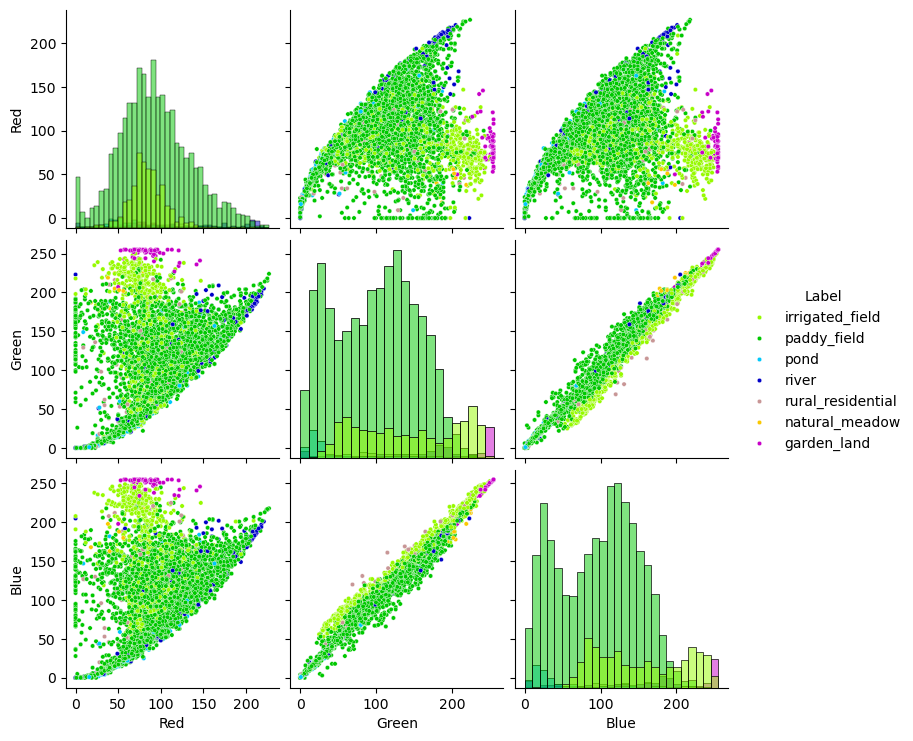

In [54]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

feature_names = ['Red', 'Green', 'Blue']
subset = np.random.choice(len(X_train), size=5000, replace=False)

# Convert X_train and y_train into a DataFrame for Seaborn
df = pd.DataFrame(X_train[subset], columns=feature_names)
df['Label'] = label_names[y_train[subset]]

palette = {name:color for name, color in zip(label_names, label_colors/255.0)}

# Create the pairplot using Seaborn
warnings.filterwarnings('ignore', 'The palette list has more values')  # Suppress warning about unused labels
g = sns.pairplot(df, hue='Label', palette=palette, diag_kind='hist', 
                 plot_kws={'s': 10, 'alpha': 1})  # Customize point size and transparency


# Show the plot
plt.show()


### Unsupervised Classification: K-Means Clustering

- K-Means partitions data into K clusters based on feature similarity
- Uses Euclidean distance by default
- Best when data forms equally sized round clusters....

In [55]:
from sklearn.cluster import KMeans

In [56]:
# Define number of clusters (e.g., number of classes)
k = 7 

In [63]:
from sklearn.pipeline import make_pipeline

# Initialize K-Means
scaler = StandardScaler()
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans_model = make_pipeline(scaler, kmeans)


In [64]:
# Fit K-Means on training data
kmeans_model.fit(X_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=7, random_state=42))])

In [65]:
# Predict clusters on test data
clusters = kmeans_model.predict(X_test)

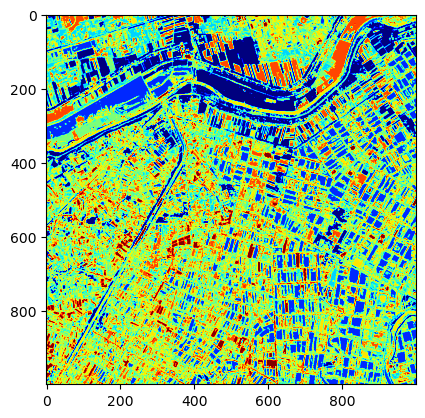

In [67]:
preds = kmeans_model.predict(image.reshape(-1, image.shape[2]))
plt.imshow(preds.reshape(image.shape[:2]), cmap='jet')

In [75]:
from sklearn.metrics import silhouette_score
test_subset = np.random.choice(len(X_test), size=1000, replace=False)
print("Silhouette Score:",silhouette_score(scaler.transform(X_test[test_subset]), clusters[test_subset]))

Silhouette Score: 0.40045552090017433


### Supervised Classification: K-Nearest Neighbors (KNN)

- KNN classifies a sample based on majority vote of its neighbors
- Distance measures: Euclidean (L2), Manhattan (L1), etc.

In [76]:
from sklearn.neighbors import KNeighborsClassifier

In [78]:
# Initialize KNN with Euclidean distance
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn_model = make_pipeline(scaler, knn, verbose=True)

In [79]:
# Fit KNN
knn_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier',
                 KNeighborsClassifier(metric='euclidean'))])

In [80]:
# Predict on test data
y_pred_knn = knn_model.predict(X_test)  #Takes about 10s to run

KNN Classification Report:
                   precision    recall  f1-score   support

      paddy_field       0.90      0.95      0.93    129285
  irrigated_field       0.79      0.73      0.76     27825
      garden_land       0.88      0.81      0.84      2567
   natural_meadow       0.62      0.34      0.44       203
            river       0.69      0.25      0.37      3765
             pond       0.48      0.25      0.33      4041
rural_residential       0.56      0.16      0.25      1722

         accuracy                           0.87    169408
        macro avg       0.70      0.50      0.56    169408
     weighted avg       0.86      0.87      0.86    169408

Accuracy: 0.8749


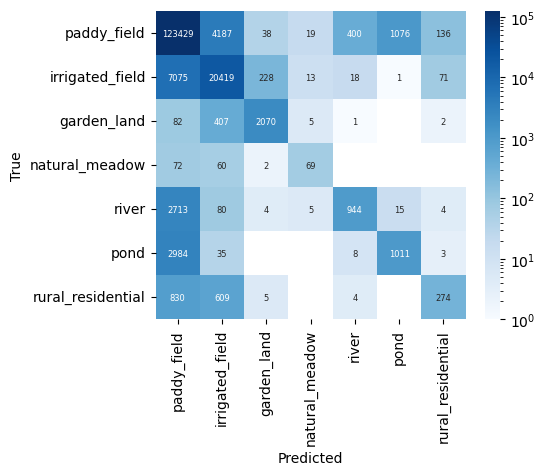

Predicting the labels for the entire image...


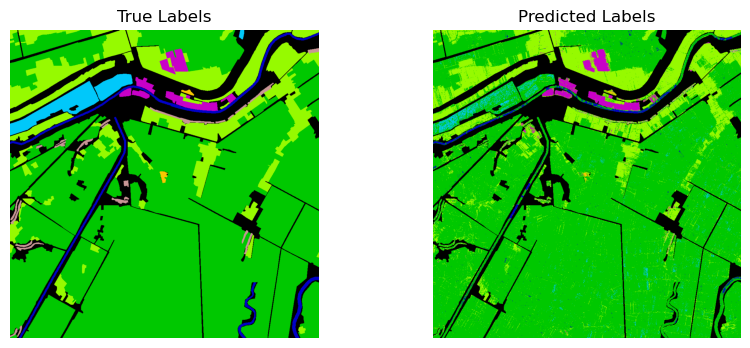

In [97]:
# Evaluate

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix


def evaluate_classification(model, name, test_preds=None):
    # Use globals X_test, y_test, image, mask

    if test_preds is None:
        test_preds = model.predict(X_test)

    print(f"{name} Classification Report:")
    print(classification_report(y_test, test_preds, 
                                labels=used_labels,
                                target_names=label_names[used_labels],
                                zero_division=np.nan)) 
    print(f'Accuracy: {accuracy_score(y_test, test_preds):.4f}')

    # Display confusion matrix
    cm = confusion_matrix(y_test, y_pred_knn)

    # Display confusion matrix using Seaborn's heatmap
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", norm='log',
                xticklabels=label_names[used_labels], 
                yticklabels=label_names[used_labels],
                annot_kws=dict(size=6))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Display the image...
    print("Predicting the labels for the entire image...")
    pred_labels = model.predict(image.reshape(-1, image.shape[2])).reshape(image.shape[:2])
    pred_rgb = label_colors[pred_labels]
    pred_rgb[~mask] = 0 # Set unlabeled pixels to black

    plt.figure(figsize=(10,4))
    plt.subplot(121)
    plt.imshow(labels_rgb)
    plt.title('True Labels')
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(pred_rgb)
    plt.title('Predicted Labels')
    plt.axis('off')

    
evaluate_classification(knn_model, 'KNN', test_preds=y_pred_knn) # Takes a minute to run

In [114]:
probs = knn_model.predict_proba(image.reshape(-1, image.shape[2]))
probs.shape

(1000000, 7)

In [113]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=used_labels, y=y_train)
class_weights

array([  0.18719318,   0.86977433,   9.42775057, 118.92400842,
         6.42704441,   5.98887298,  14.05402771])

In [205]:
scaled_probs = probs * class_weights
scaled_label_indices = np.argmax(scaled_probs, axis=1)
scaled_labels = used_labels[scaled_label_indices].reshape(image.shape[:2])

(np.float64(-0.5), np.float64(999.5), np.float64(999.5), np.float64(-0.5))

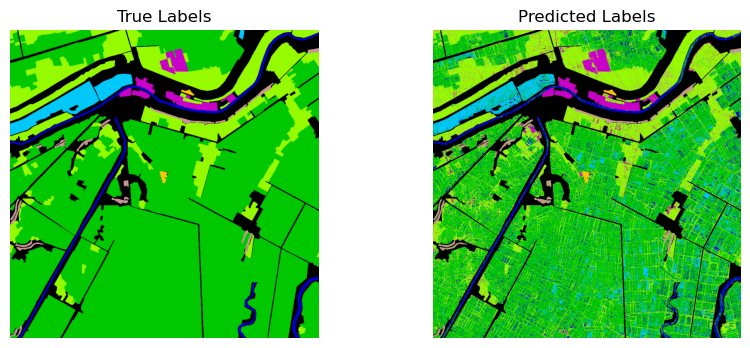

In [206]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(labels_rgb)
plt.title('True Labels')
plt.axis('off')
plt.subplot(122)
plt.imshow(label_colors[scaled_labels]*mask[...,None])
plt.title('Predicted Labels')
plt.axis('off')


In [207]:
# %conda install -y -c conda-forge pydensecrf

In [208]:
import numpy as np
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax

In [209]:
d = dcrf.DenseCRF2D(image.shape[1], image.shape[0], len(used_labels))

unary = unary_from_softmax(scaled_probs.T)  # (7, 1000000)

# ISing model
d.setUnaryEnergy(unary.copy())
d.addPairwiseGaussian(sxy=5, compat=15)
d.addPairwiseBilateral(sxy=2, srgb=15, rgbim=image.copy(), compat=25)

Q = d.inference(1) # num iterations

crf_labels = used_labels[np.argmax(Q, axis=0)].reshape(image.shape[:2])


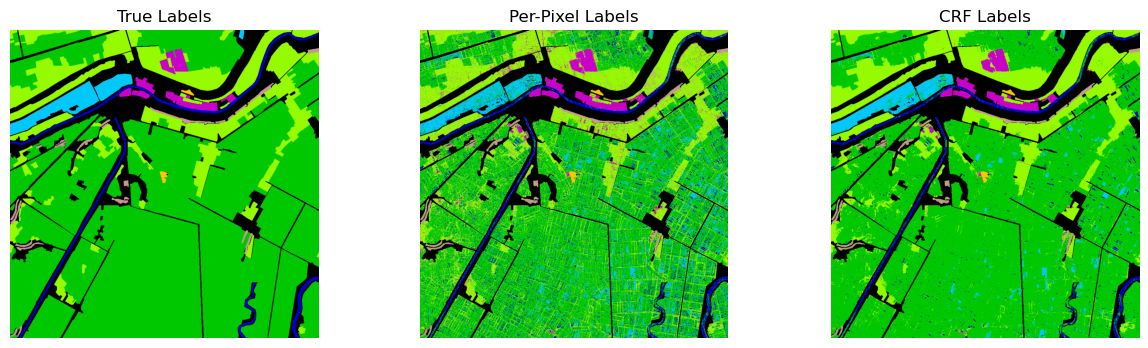

In [212]:
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.imshow(labels_rgb)
plt.title('True Labels')
plt.axis('off')
plt.subplot(132)
plt.imshow(label_colors[scaled_labels]*mask[...,None])
plt.title('Per-Pixel Labels')
plt.axis('off')
plt.subplot(133)
plt.imshow(label_colors[crf_labels]*mask[...,None])
plt.title('CRF Labels')
plt.axis('off')
plt.show()

### Supervised Classification: Naive Bayes Classifier

**Overview:**
- Assumes feature independence
- Suitable for high-dimensional data

In [227]:
from sklearn.naive_bayes import GaussianNB

# Initialize Gaussian Naive Bayes
nb = GaussianNB()

nb_model = make_pipeline(scaler, nb, verbose=True)
nb_model.steps

[('standardscaler', StandardScaler()), ('gaussiannb', GaussianNB())]

In [228]:

to_used_index = np.zeros(len(label_names), dtype=int)
to_used_index[used_labels] = np.arange(len(used_labels))
sample_weights = class_weights[to_used_index[y_train]]


# Fit Naive Bayes
nb_model.fit(X_train, y_train, gaussiannb__sample_weight=sample_weights)

[Pipeline] .... (step 1 of 2) Processing standardscaler, total=   0.1s
[Pipeline] ........ (step 2 of 2) Processing gaussiannb, total=   0.1s


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gaussiannb', GaussianNB())],
         verbose=True)

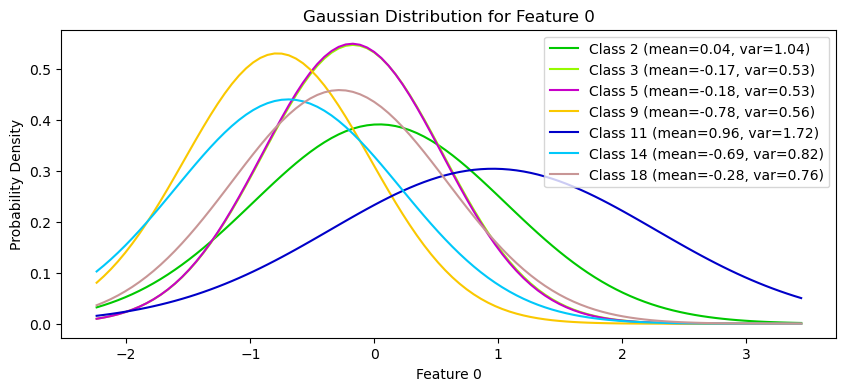

In [229]:
# Visualize the Gaussian distribution for each class

from scipy.stats import norm

# Select a single feature (e.g., the first feature, index 0)
feature_index = 0

X_trian_normalized = scaler.transform(X_train)[:, feature_index]

# Generate a range of values along this axis for visualization
x_axis = np.linspace(min(X_trian_normalized), max(X_trian_normalized), 100)


plt.figure(figsize=(10,4))

# Plot the Gaussian distribution for each class
for i, class_label in enumerate(nb.classes_):
    # Get mean and variance for the current class and feature
    mean = nb.theta_[i, feature_index]
    var = np.sqrt(nb.var_[i, feature_index])
    
    # Compute the Gaussian PDF for the range of x values
    pdf = norm.pdf(x_axis, mean, np.sqrt(var))
    
    # Plot the distribution
    plt.plot(x_axis, pdf, color=label_colors[class_label]/255.,  label=f'Class {class_label} (mean={mean:.2f}, var={var:.2f})')

# Add labels and legend
plt.title(f'Gaussian Distribution for Feature {feature_index}')
plt.xlabel(f'Feature {feature_index}')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

GaussianNB Classification Report:
                   precision    recall  f1-score   support

      paddy_field       0.90      0.95      0.93    129285
  irrigated_field       0.79      0.73      0.76     27825
      garden_land       0.88      0.81      0.84      2567
   natural_meadow       0.62      0.34      0.44       203
            river       0.69      0.25      0.37      3765
             pond       0.48      0.25      0.33      4041
rural_residential       0.56      0.16      0.25      1722

         accuracy                           0.87    169408
        macro avg       0.70      0.50      0.56    169408
     weighted avg       0.86      0.87      0.86    169408

Accuracy: 0.8749


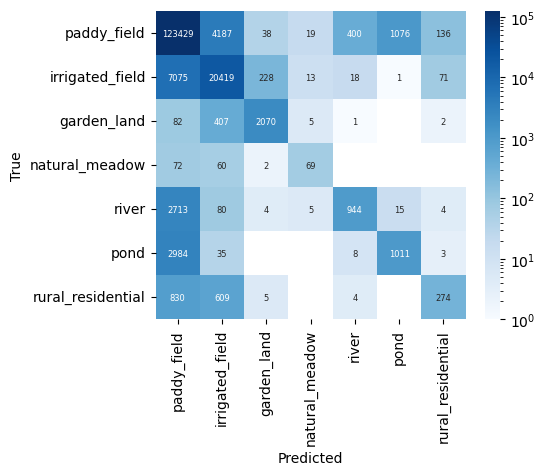

Predicting the labels for the entire image...


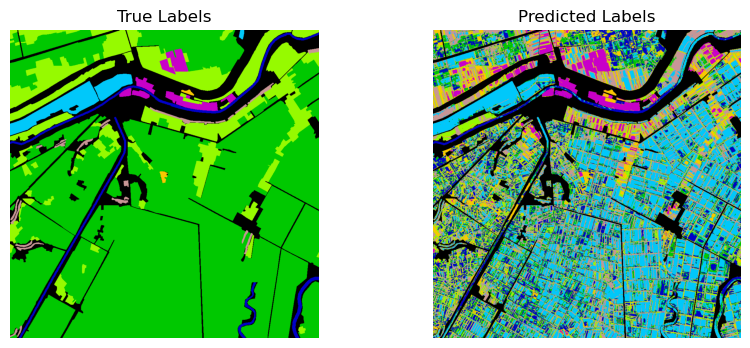

In [230]:
    
evaluate_classification(nb_model, 'GaussianNB', test_preds=y_pred_knn) # Takes a minute to run

### Supervised Classification: Decision Tree

**Overview:**
- Tree-based model that splits data based on feature values
- Easy to interpret

In [233]:
from sklearn.tree import DecisionTreeClassifier
# Initialize Decision Tree

dt = DecisionTreeClassifier(random_state=42, max_depth=15)

dt_model = make_pipeline(scaler, dt, verbose=True)

# Fit Decision Tree
dt_model.fit(X_train, y_train, decisiontreeclassifier__sample_weight=sample_weights)

[Pipeline] .... (step 1 of 2) Processing standardscaler, total=   0.1s
[Pipeline]  (step 2 of 2) Processing decisiontreeclassifier, total=   1.6s


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=15, random_state=42))],
         verbose=True)

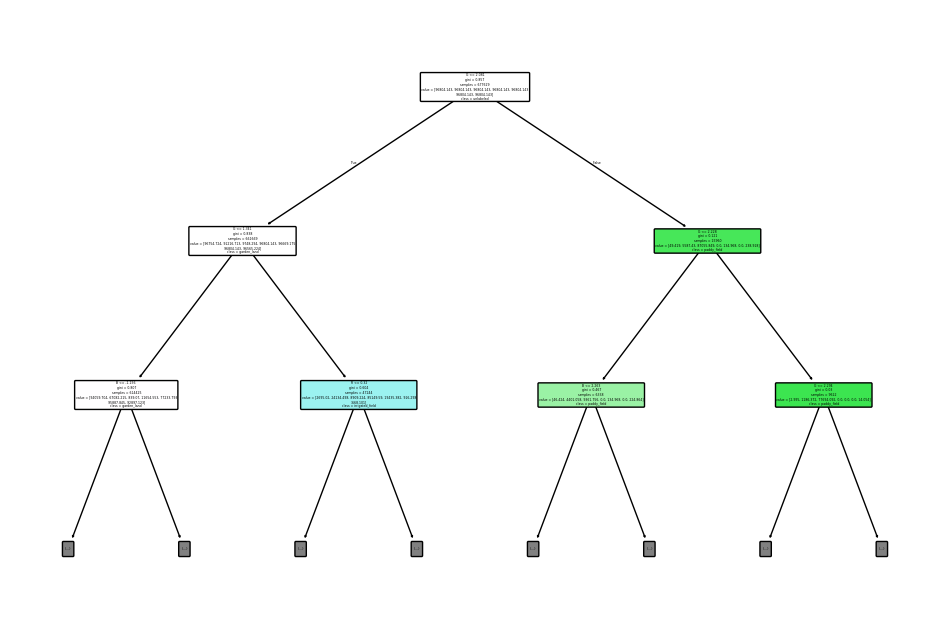

In [237]:
from sklearn.tree import plot_tree

# Plot the decision tree
plt.figure(figsize=(12,8))  # Adjust the figure size as needed
plot_tree(dt, filled=True, rounded=True, max_depth=2, 
          feature_names=['R', 'G', 'B', 'NiR'], 
          class_names=label_names)
plt.show()

Decision Tree Classification Report:
                   precision    recall  f1-score   support

      paddy_field       0.96      0.52      0.67    129285
  irrigated_field       0.55      0.76      0.64     27825
      garden_land       0.71      0.86      0.78      2567
   natural_meadow       0.03      0.72      0.06       203
            river       0.11      0.68      0.19      3765
             pond       0.19      0.72      0.30      4041
rural_residential       0.07      0.55      0.12      1722

         accuracy                           0.57    169408
        macro avg       0.37      0.69      0.39    169408
     weighted avg       0.84      0.57      0.64    169408

Accuracy: 0.5745


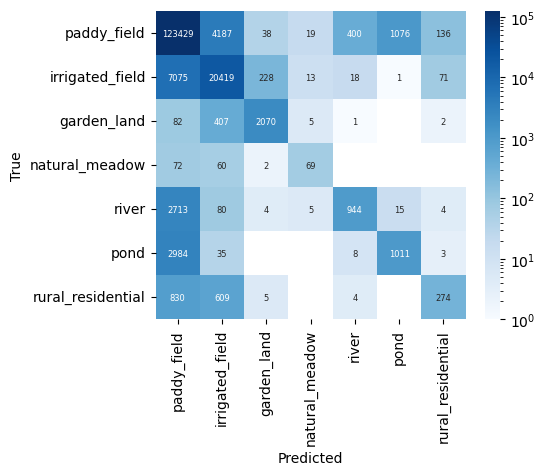

Predicting the labels for the entire image...


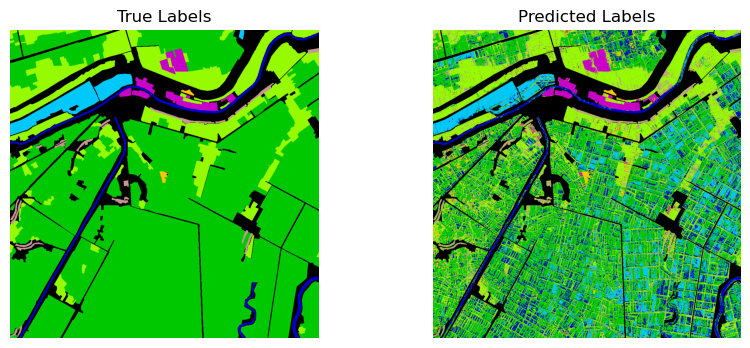

In [238]:

evaluate_classification(dt_model, 'Decision Tree') 

### Supervised Classification: Random Forest

**Overview:**
- Ensemble of decision trees
- Reduces overfitting and improves accuracy

Random Forest Classification Report:
                   precision    recall  f1-score   support

      paddy_field       0.91      0.82      0.87    129285
  irrigated_field       0.72      0.75      0.73     27825
      garden_land       0.84      0.82      0.83      2567
   natural_meadow       0.55      0.43      0.48       203
            river       0.19      0.40      0.25      3765
             pond       0.23      0.64      0.34      4041
rural_residential       0.21      0.18      0.19      1722

         accuracy                           0.79    169408
        macro avg       0.52      0.58      0.53    169408
     weighted avg       0.84      0.79      0.81    169408

Accuracy: 0.7914


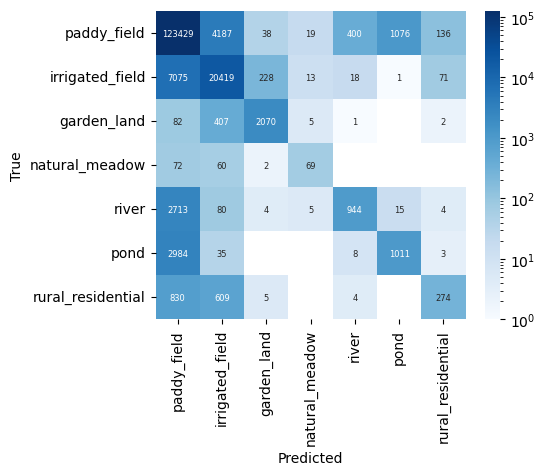

Predicting the labels for the entire image...


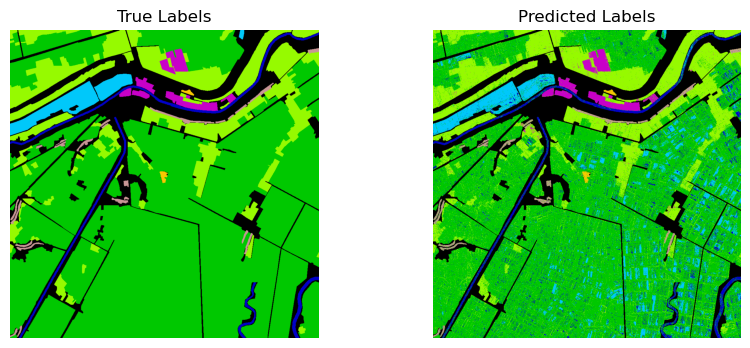

In [243]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

X_train_scaled = scaler.transform(X_train)  # Avoid refitting scaler

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train, sample_weight=sample_weights)

rf_model = Pipeline([('scaler', scaler), ('rf', rf)])

evaluate_classification(rf_model, 'Random Forest') 

### Supervised Classification: Gradient Boosting

**Overview:**
- Ensemble method that builds trees sequentially
- Each tree corrects errors of the previous ones

In [248]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=15, learning_rate=0.1, random_state=42)

gb.fit(X_train_scaled, y_train, sample_weight=sample_weights)

gb_model = Pipeline([('scaler', scaler), ('gb', gb)])

Gradient Boosting Classification Report:
                   precision    recall  f1-score   support

      paddy_field       0.94      0.42      0.58    129285
  irrigated_field       0.51      0.49      0.50     27825
      garden_land       0.54      0.93      0.68      2567
   natural_meadow       0.02      0.91      0.05       203
            river       0.11      0.62      0.19      3765
             pond       0.10      0.78      0.17      4041
rural_residential       0.05      0.56      0.09      1722

         accuracy                           0.45    169408
        macro avg       0.32      0.67      0.32    169408
     weighted avg       0.82      0.45      0.54    169408

Accuracy: 0.4510


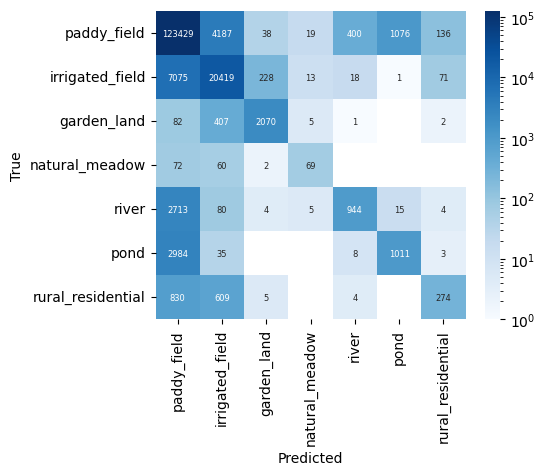

Predicting the labels for the entire image...


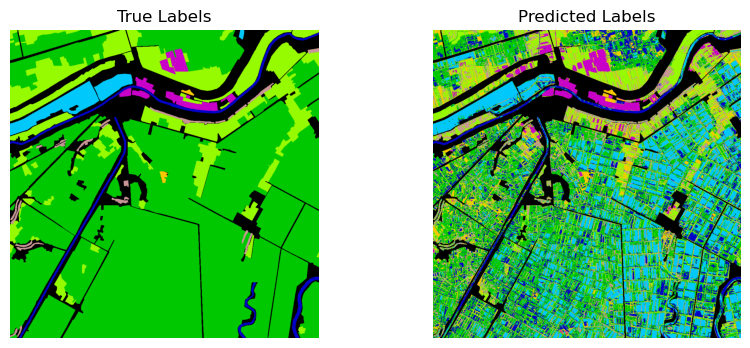

In [249]:
evaluate_classification(gb_model, 'Gradient Boosting') 

### Supervised Classification: Multi-Layer Perceptron (MLP) Classifier

**Overview:**
- Feedforward neural network
- Can capture complex relationships

In [252]:
from sklearn.neural_network import MLPClassifier
# Initialize MLP Classifier
mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10),  max_iter=30, random_state=42)
mlp.fit(X_train, y_train)

# No sample weights or class weights for the built-in  MLP in sklearn

mlp_model = Pipeline([('scaler', scaler), ('mlp', mlp)])


/opt/anaconda3/envs/cse620b-shared/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:

evaluate_classification(mlp_model, 'MLP') 